# Training on a pooled Deep Neural Network with manual convolution using atlas
I wrote a simple Keras Model which pools 3D objects into 1D using GlobalAveragePooling. 
Then this 1D was pushed into a Dense layer of 1024, and then softmax output layer of 5.
Majority work here is cleaning and organizing data so that it fit into the model.

Note: A lot of times running this code led to memory exceeded errors just due to the size of these
datasets, so I would do data cleaning + Manual Convolution first, save the data, close the kernel, and then run the model training section. Also, I haven't checked test accuracy yet - just comparing using validation accuracy

### Data Cleaning
Putting all the data together, cleaning formats, removing NaN values - making sure it can be input into a model

In [2]:
import numpy as np

In [3]:
# Importing all data
data = [np.load('data/resized/fractals_' + str(i) + '.npy').item() for i in range(1, 202)]
len(data)

201

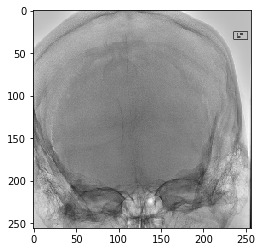

In [4]:
# Data Sanity Check
import matplotlib.pyplot as plt
plt.imshow(data[0]['X'][:, :, 0], cmap='gray')

In [5]:
# Creating a dataframe to house the data
import pandas as pd
df = pd.DataFrame(data)
df = df.drop(['__globals__', '__header__', '__version__'], axis=1)
df['y'] = 0 # New column in which I'll fill values

In [6]:
# This creates a new column 'y' that contains a TICI score if any of TICI_report, TICI_Dr1, or TICI_Dr2 are not null.
# This can then be used as our label in our image classification project.
def get_y(x):
    yr = x['TICI_report'][0]
    yd1 = x['TICI_Dr1'][0]
    yd2 = x['TICI_Dr2'][0]
    if (isinstance(yr, np.ndarray)):
        yr = yr[0]
    if (isinstance(yd1, np.ndarray)):
        yd1 = yd1[0]
    if(isinstance(yd2, np.ndarray)):
        yd2 = yd2[0]
    if (yr != 'nan'):
        return yr
    if(yd1 != 'nan'):
        return yd1
    elif(yd2 != 'nan'):
        return yd2
    return 'nan'

df['y'] = df.apply(lambda x: get_y(x), axis=1)

In [7]:
# We don't need the 'TICI_Dr1', 'TICI_Dr2' or 'TICI_report' columns anymore
data = df[['X', 'y']]

In [8]:
clean_data = data.dropna(how='any')
clean_data.loc[clean_data['y'] == '0 (bilateral MCA)', ['y']]= 0

# For this datapoint, I thought '2a?' might be another type of category, but
# I believe there is only one data point that has '2a?' as a category so I'm
# going to treat it as an error and convert it to '2a'
clean_data.loc[clean_data['y'] == '2a?', ['y']] = '2a'
len(clean_data)

/home/jupyter/.local/lib/python3.5/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


181

### Train-Test Split and to_categorical
Keeping a section of the data away from the model for final comparison, as well as converting categorical values into one-hot encoding for
the model to be able to comprehend.

In [9]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.1
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(clean_data.drop('y', axis=1), clean_data['y'], test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False, stratify=None)

In [10]:
# to_categorical (I used pd.get_dummies because they work with dataframes and return column name)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
# I made the entirety of y_test[1] = 0 as for this random_state y_test has no objects of TICI 1
y_test[1] = 0
# This is to order the columns 
cols = [0, 1, '2a', '2b', 3]
y_train = y_train[cols]
y_test = y_test[cols]
y_train.columns, y_test.columns

(Index([0, 1, '2a', '2b', 3], dtype='object'),
 Index([0, 1, '2a', '2b', 3], dtype='object'))

In [11]:
# Converting Pandas DataFrames into numpy arrays, which keras supports
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [12]:
# Shape sanity check pt II
X_train[161][0].shape

(256, 256, 39)

In [13]:
# Exceeds memory at this point
(X_train.shape, y_train.shape, X_test.shape,  y_test.shape)

((162, 1), (162, 5), (19, 1), (19, 5))

### Manual Convolution
Here I run our dataset through scipy's fftconvolve and use the atlas as the manual filter, as the first stage in the machine learning. (This is just me trying things just to see how they would turn out)

In [14]:
atlas = np.load('data/atlas.npy')
atlas.shape

(256, 256, 39)

In [15]:
import sys # This is because I'm extra and I wanted to see if I could actually do a progress bar
from scipy.signal import fftconvolve

X_train_in = np.zeros((162, 256, 256, 39))
for i in range(0, X_train_in.shape[0]):
    sys.stdout.write('\r')
    sys.stdout.write('[' + np.ceil(i/2).astype(int)*'#' + np.ceil(((X_train_in.shape[0] - i)/2) - 1).astype(int)*'.' + ']' + str(i))
    sys.stdout.flush()
    X_train_in[i] = fftconvolve(X_train[i][0], atlas, mode='same')

[#################################################################################]161

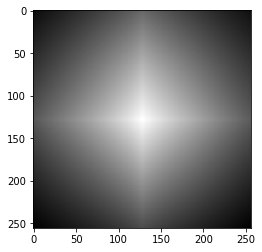

In [16]:
plt.imshow(X_train_in[0][:, :, 0], cmap='gray')

In [17]:
# Converting X_train into shape (162, 256, 256, 39) - otherwise it was an array of np.arrays
X_train.shape
X_train_new = np.zeros((162, 256, 256, 39))
for i in range(0, len(X_train)):
    print(i, end=' ')
    X_train_new[i] = X_train[i][0]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 

In [18]:
np.save('data/manual_conv/X_train_in.npy', X_train_in)

In [19]:
np.save('data/manual_conv/X_train.npy', X_train_new)

In [20]:
np.save('data/manual_conv/X_test.npy', X_test)

In [21]:
np.save('data/manual_conv/y_train.npy', y_train)

In [22]:
np.save('data/manual_conv/y_test.npy', y_test)

### Model Definition
Trial of a basic 3D into pooled 1D DNN model - just to see what happens
(Note: close the kernel first then restart it, then run these steps separately NOT THE STEPS ABOVE, otherwise memory gets exceeded) 

TL;DR - manual convolution doesn't help (val. acc. 30% with, 40% without)

In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input, Dense, GlobalAveragePooling3D
from keras.models import Model

# shape: (None, spatial_dim1, spatial_dim2, spatial_dim3, channels)
input_img = Input(shape=(256, 256, 39, 1))

# Nothing, just your standard multi-layer perceptron (I based this off of Simi's code)
x = GlobalAveragePooling3D()(input_img)
x = Dense(1024, activation='relu', use_bias=True)(x)
output = Dense(5, activation='softmax', use_bias=True)(x)

model = Model(inputs=input_img, outputs=output)
rmsprop = keras.optimizers.RMSprop(lr=0.005)
model.compile(optimizer=rmsprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 39, 1)   0         
_________________________________________________________________
global_average_pooling3d_1 ( (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2048      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,173
Trainable params: 7,173
Non-trainable params: 0
_________________________________________________________________


### Model fitting and training

In [2]:
# Load these values in separately, so that memory doesn't get exceeded
X_train_conv = np.load('data/manual_conv/X_train_in.npy')

In [3]:
X_train = np.load('data/manual_conv/X_train.npy')

In [4]:
y_train = np.load('data/manual_conv/y_train.npy')

#### Training with manual convolution

In [5]:
model.fit(X_train_conv[:, :, :, :, np.newaxis], y_train, epochs=10, batch_size=50, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
162/162 [==============================] - 6s 35ms/step - loss: 5.1010 - acc: 0.3148
Epoch 2/10
162/162 [==============================] - 5s 29ms/step - loss: 9.3034 - acc: 0.2099
Epoch 3/10
162/162 [==============================] - 4s 28ms/step - loss: 9.5515 - acc: 0.4074
Epoch 4/10
162/162 [==============================] - 5s 28ms/step - loss: 9.5515 - acc: 0.4074
Epoch 5/10
162/162 [==============================] - 5s 28ms/step - loss: 9.5515 - acc: 0.4074
Epoch 6/10
162/162 [==============================] - 4s 28ms/step - loss: 9.5515 - acc: 0.4074
Epoch 7/10
162/162 [==============================] - 5s 28ms/step - loss: 9.5515 - acc: 0.4074
Epoch 8/10
162/162 [==============================] - 5s 28ms/step - loss: 9.5515 - acc: 0.4074
Epoch 9/10
162/162 [==============================] - 5s 28ms/step - loss: 9.5515 - acc: 0.4074
Epoch 10/10
162/162 [==============================] - 5s 28ms/step - loss: 9.5515 - acc

Validation accuracy for this basic model is around 40% - which isn't that great

#### Training without manual convolution

In [6]:
model.fit(X_train[:, :, :, :, np.newaxis], y_train, epochs=10, batch_size=50, verbose=1)

Epoch 1/10
162/162 [==============================] - 5s 28ms/step - loss: 3.2058 - acc: 0.4074
Epoch 2/10
162/162 [==============================] - 5s 28ms/step - loss: 1.4480 - acc: 0.4074
Epoch 3/10
162/162 [==============================] - 5s 30ms/step - loss: 1.4058 - acc: 0.4074
Epoch 4/10
162/162 [==============================] - 5s 28ms/step - loss: 1.3770 - acc: 0.4074
Epoch 5/10
162/162 [==============================] - 5s 28ms/step - loss: 1.4067 - acc: 0.4074
Epoch 6/10
162/162 [==============================] - 5s 29ms/step - loss: 1.3954 - acc: 0.3519
Epoch 7/10
162/162 [==============================] - 5s 29ms/step - loss: 1.3787 - acc: 0.4074
Epoch 8/10
162/162 [==============================] - 5s 28ms/step - loss: 1.3876 - acc: 0.3765
Epoch 9/10
162/162 [==============================] - 4s 28ms/step - loss: 1.3956 - acc: 0.3765
Epoch 10/10
162/162 [==============================] - 4s 28ms/step - loss: 1.3792 - acc: 0.4074


Down with the atlas then - the simple model without any manual convolution does as well as than the one with! 

Note: Both these models seem to reach high validation accuracies (and low loss values) and then decrease with the next batch. Perhaps the models are too simplistic, I don't know. The loss values seem to converge to the same value - 9.5515 for the manual convolution and the mean pooling model below. I believe this means that perhaps the optimizer isn't tuned properly - maybe the learning rate is too high.

### Mean pooling 3D into Inception
I'm trying out different stuff in this notebook just to see what we get (and so we can show we discarded these ideas). In this part, I'm going to take the mean (across the time axis) of our patients and push it through inception to see what we get.

TL;DR - not great, at least not with this configuration (around 40% as well)

In [2]:
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

# Inception needs images of shape (256, 256, 3) - needs three channels as well
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (256, 256, 3)) 

# DNN portion
# average pooling layer
x = GlobalAveragePooling2D()(base_model.output)
# fully-connected layer
x = Dense(1024, activation='relu')(x)
# logistic layer
output = Dense(5, activation='softmax')(x) # 5 is the number of classes in the data, since TICI is 0,1,2a,2b,3

model_inception = Model(inputs=base_model.input, outputs=output)
rmsprop = keras.optimizers.RMSprop(lr=0.005)
model_inception.compile(optimizer=rmsprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_inception.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
_____________________________________

In [3]:
import numpy as np

In [5]:
X_train = np.load('data/manual_conv/X_train.npy')
y_train = np.load('data/manual_conv/y_train.npy')

In [ ]:
# I'm reducing the data by taking a mean over the time axis. However, I'm creating three clones at positions 0
# 1, and 2 on the time axis so that they can be passed as channels into Inception.
X_train_inception = np.zeros((X_train.shape[0], 256, 256, 3))
for i in range(0, X_train.shape[0]):
    mean = np.mean(X_train[i], axis=2)
    X_train_inception[i, :, :, 0] = mean
    X_train_inception[i, :, :, 1] = mean
    X_train_inception[i, :, :, 2] = mean

In [ ]:
np.save('data/manual_conv/X_train_inception.npy', X_train_inception)

In [4]:
X_train_inception = np.load('data/manual_conv/X_train_inception.npy')

In [6]:
model_inception.fit(X_train_inception, y_train, epochs=10, batch_size=50, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
162/162 [==============================] - 104s 642ms/step - loss: 7.6728 - acc: 0.2778
Epoch 2/10
162/162 [==============================] - 57s 350ms/step - loss: 9.5515 - acc: 0.4074
Epoch 3/10
162/162 [==============================] - 58s 356ms/step - loss: 9.5515 - acc: 0.4074
Epoch 4/10
162/162 [==============================] - 58s 359ms/step - loss: 9.5515 - acc: 0.4074
Epoch 5/10
162/162 [==============================] - 57s 352ms/step - loss: 9.5515 - acc: 0.4074
Epoch 6/10
162/162 [==============================] - 57s 355ms/step - loss: 9.5515 - acc: 0.4074
Epoch 7/10
162/162 [==============================] - 57s 352ms/step - loss: 9.5515 - acc: 0.4074
Epoch 8/10
162/162 [==============================] - 56s 347ms/step - loss: 9.5515 - acc: 0.4074
Epoch 9/10
162/162 [==============================] - 56s 347ms/step - loss: 9.5515 - acc: 0.4074
Epoch 10/10
162/162 [==============================] - 58s 356ms/step

Validation accuracy around 40% - no improvement from basic 3D pooling model. I really should calculate test accuracy for these models one of these days